In [1]:
import pandas as pd
from textblob import TextBlob
import nltk
import math
import matplotlib
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from library.clean import mask, double_mask
from library.analyze import df_to_li, stem_li, remove_stopwords, join_words, get_tf, calc_idf, get_tf_idf 

In [3]:
# load data as dataframe

df = pd.read_pickle('data/re_merge/clean.pickle')
df['hl_lead'] = df['hl'] + ' '+ df['lead']
#df = df[df['date_pub'] <= '2016-02-31'] 
df.reset_index(inplace=True)
df['year'] = df['date_pub'].dt.year
df['half_dec'] = ((df['year'] % 1900)/5).astype(int)*5 # create column of half-decades

df.head(100)

,index,nyt_id,org,hl,lead,date_pub,hl_lead,year,half_dec
0,3,4fc0a09745c1498b0d3ba216,none,marijuana smoking is reported safe hemp leaves...,a panaman judge recently sentenced an american...,1926-11-21,marijuana smoking is reported safe hemp leaves...,1926,25
1,9,4fc1d8e345c1498b0d4ccb9f,none,use of marijuana spreading in west poisonous w...,although as appalling in its effects on the hu...,1934-09-16,use of marijuana spreading in west poisonous w...,1934,30
2,12,4fc1ebab45c1498b0d528e5b,the associated press,rhode island to end weed as drug source state ...,providence ri jan 19 rhode island authorities ...,1935-01-20,rhode island to end weed as drug source state ...,1935,35
3,18,4fc1e47f45c1498b0d505955,none,police study marijuana to kill growing crops,to enable policemen to familiarize themselves ...,1936-07-24,police study marijuana to kill growing crops t...,1936,35
4,19,4fc1fc6445c1498b0d578c35,none,3000000 bonfire destroys marijuana police burn...,at bootleg prices of marijuana weed which is ...,1936-08-14,3000000 bonfire destroys marijuana police burn...,1936,35
5,20,4fc1e92c45c1498b0d51c3fa,none,5 acres of marijuana uprooted by police barren...,the police began uprooting yesterday a fiveacr...,1936-08-19,5 acres of marijuana uprooted by police barren...,1936,35
6,30,4fc2051f45c1498b0d5a1f00,none,world group to push fight on marijuana illicit...,with special emphasis on the increasing use of...,1937-02-21,world group to push fight on marijuana illicit...,1937,35
7,44,4fc2019145c1498b0d592436,none,drive on narcotics sped by treasury campaign t...,the virtual elimination of rumrunning from the...,1938-01-31,drive on narcotics sped by treasury campaign t...,1938,35
8,45,4fc1fef745c1498b0d58582e,none,mrs sohl admits holdup shooting but says narco...,attributing her brief criminal career to addic...,1938-02-11,mrs sohl admits holdup shooting but says narco...,1938,35
9,47,4fc1fec245c1498b0d5848c5,none,insanity stressed in mrs sohls case her defens...,further testimony intended to show that mrs et...,1938-02-13,insanity stressed in mrs sohls case her defens...,1938,35


In [48]:
li = df_to_li(df, 'hl_lead'); li[0]
#li_stemmed = stem_li(li); li_stemmed[0]
#li_sw = remove_stopwords(li_stemmed); li_sw[0]
#documents = join_words(li_sw); documents[0]

'marijuana smoking is reported safe hemp leaves classed in some states with drugs tested by canal zone committee experiment made on 17 panaman judge recently gave sailor a years sentence for possessing the weed a panaman judge recently sentenced an american seaman hamilton main to a year of penal confinement for smoking and having in his possession cigarettes made of the leaves of the cannabis indica known also as marijuana canjac and by various other names and often incorrectly referred to as hashish'

In [49]:
cleaned = pd.Series(li, name = 'clean'); cleaned.head(3)

0    marijuana smoking is reported safe hemp leaves...
1    use of marijuana spreading in west poisonous w...
2    rhode island to end weed as drug source state ...
Name: clean, dtype: object

In [50]:
result = df.join(cleaned)
result.drop(['index', 'nyt_id', 'org', 'hl', 'lead', 'hl_lead', 'year'], axis=1, inplace=True)
result.head(3)

,date_pub,half_dec,clean
0,1926-11-21,25,marijuana smoking is reported safe hemp leaves...
1,1934-09-16,30,use of marijuana spreading in west poisonous w...
2,1935-01-20,35,rhode island to end weed as drug source state ...


In [51]:
df_half_dec = result.groupby('half_dec')['clean'].apply(lambda x: '%s' % ' '.join(x)).to_frame(name='clean')
df_half_dec = df_half_dec.loc[df_half_dec.index >= 35]
df_half_dec.head(3)

,clean
half_dec,
35,rhode island to end weed as drug source state ...
40,the play the play called sweet charity that ha...
45,experts discount marijuana as big factor in cr...


In [52]:
li = df_to_li(df_half_dec, 'clean'); len(li)

17

In [122]:
add_on_stop_words = ['tomorrow','sunday','thursday','sisario','730','wednesday','tonight','tonight tomorrow', 'a1','212','2396200','212 2396200','said', 'say', 'said today', 'today', 'brantley', 'chinen', 'street brantley', 'tonight tomorrow', '10', '100']
ultimate_stop_words = text.ENGLISH_STOP_WORDS.union(add_on_stop_words)
tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', decode_error='replace', strip_accents='unicode', analyzer='word', ngram_range=(1,4), stop_words=ultimate_stop_words)
tfidf = tfidf_vectorizer.fit_transform(li)
pca = PCA(n_components=12)
tfidf_pca = pca.fit_transform(tfidf.toarray())
explained_variance = pca.explained_variance_ratio_

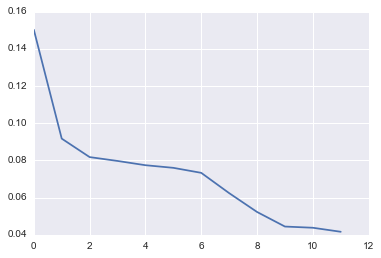

In [123]:
plt.plot(explained_variance)

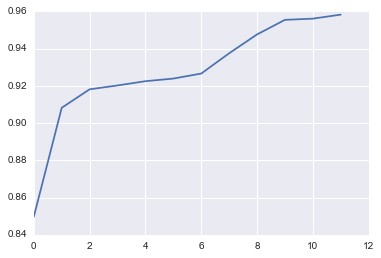

In [124]:
plt.plot((np.ones(12) - explained_variance))

In [146]:
X_top_1 = (tfidf_pca.T[:1]).T
X_top_2 = (tfidf_pca.T[:2]).T
X_top_9 = (tfidf_pca.T[:9]).T
X_top_12 = (tfidf_pca.T[:12]).T

In [147]:
co_sim_matrix_1 = cosine_similarity(X_top_1, X_top_1)
co_sim_matrix_2 = cosine_similarity(X_top_2, X_top_2)
co_sim_matrix_9 = cosine_similarity(X_top_9, X_top_9)
co_sim_matrix_12 = cosine_similarity(X_top_12, X_top_12)

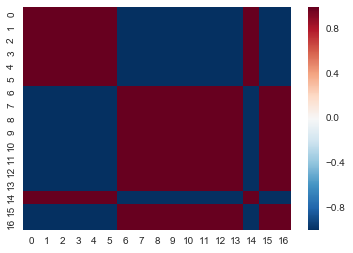

In [148]:
ax_1 = sns.heatmap(co_sim_matrix_1, cmap="RdBu_r", annot=False)

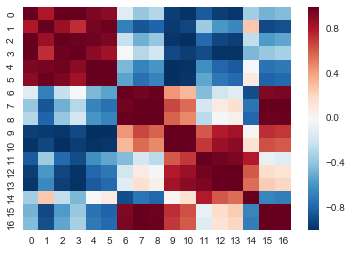

In [149]:
ax_2 = sns.heatmap(co_sim_matrix_2, cmap="RdBu_r", annot=False)

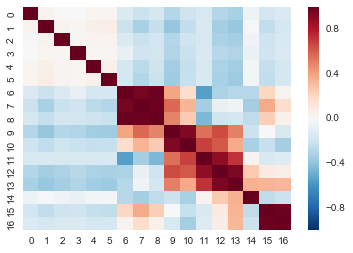

In [150]:
ax_9 = sns.heatmap(co_sim_matrix_9, cmap="RdBu_r", annot=False)

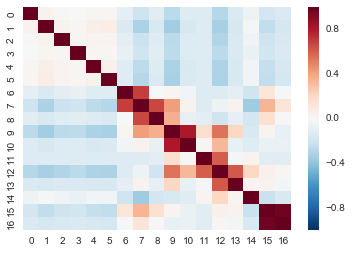

In [151]:
ax_12 = sns.heatmap(co_sim_matrix_12, cmap="RdBu_r", annot=False)

In [128]:
# clusters
lower_cutoffs = [65, 80, 90,  105, 110]
upper_cutoffs = [75, 85, 100, 105, 115]
cutoffs = zip(lower_cutoffs, upper_cutoffs); cutoffs

[(65, 75), (80, 85), (90, 100), (105, 105), (110, 115)]

In [129]:
df_bins = df_half_dec.copy()
df_bins['bin'] = 0
df_bins.reset_index(inplace=True)

for i, j in enumerate(cutoffs):
    bin_filter = (df_bins['half_dec'] >= j[0]) & (df_bins['half_dec'] <= j[1])
    df_bins.loc[bin_filter, 'bin'] = i + 1
df_bins = df_bins.loc[df_bins['bin'] > 0]
df_bins.head(3)

,half_dec,clean,bin
6,65,marijuana seizure set record for year the cust...,1
7,70,virginia governor pardons youth 20 on drug con...,1
8,75,197475 college freshman is found more conserva...,1


In [130]:
df_binned = df_bins.groupby('bin')['clean'].apply(lambda x: '%s' % ' '.join(x)).to_frame(name='clean'); df_binned.head(3)

,clean
bin,
1,marijuana seizure set record for year the cust...
2,police plan a new drive on chronic felons 25ma...
3,judge denies bail to woman extradited on drug ...


In [131]:
li2 = df_to_li(df_binned, 'clean'); li2[3]

'meeting death with a cool heart in 22 years of using bangkoks airport don muang the busiest in southeast asia i have never known it to be anything but crowded on new years eve five days after the tsunami that devastated phuket and much of the rest of southern thailand it was empty i called friends from the airport and found that nobody i knew had died but everyone knew someone who was missing from every walk of life businessmen prostitutes dealers in marijuana doctors politicians the tsunami made no social distinctions i was returning from laos where my family and i had spent the christmas vacation by the banks of the mekong in the delightful town of luang prabang when we heard the news my first thought was it could have been us i had originally planned to take us sailing in the andaman sea off phuket what chance would we have had in a small sailboat when people drowned in their hotel rooms we were saved by indolence i decided to drink laotian beer by the mekong rather than face the h

In [132]:
tfidf2_vectorizer = TfidfVectorizer(encoding='latin-1', decode_error='replace', strip_accents='unicode', analyzer='word', ngram_range=(1,4), stop_words=ultimate_stop_words)
tfidf2_ft = tfidf2_vectorizer.fit_transform(li2).toarray()
tfidf2_fn = tfidf2_vectorizer.get_feature_names(); tfidf2_fn

[u'007',
 u'007 ratty',
 u'007 ratty puny',
 u'007 ratty puny accounted',
 u'01',
 u'01 nanograms',
 u'01 nanograms cubic',
 u'01 nanograms cubic meter',
 u'011441712405224',
 u'011441712405224 concerned',
 u'011441712405224 concerned domestication',
 u'011441712405224 concerned domestication forest',
 u'012',
 u'012 percent',
 u'012 percent harvey',
 u'012 percent harvey toxicology',
 u'02',
 u'02 higher',
 u'02 higher japans',
 u'02 higher japans gdp',
 u'03',
 u'03 conviction',
 u'03 conviction arkansas',
 u'03 conviction arkansas gov',
 u'045',
 u'045 cubic',
 u'045 cubic centimeter',
 u'045 cubic centimeter ketamine',
 u'047',
 u'047 ounces',
 u'047 ounces marijuana',
 u'047 ounces marijuana 11',
 u'06',
 u'06 deadliest',
 u'06 deadliest day',
 u'06 deadliest day american',
 u'062',
 u'062 047',
 u'062 047 ounces',
 u'062 047 ounces marijuana',
 u'07',
 u'07 youngcolleen',
 u'07 youngcolleen thomas',
 u'07 youngcolleen thomas company',
 u'072',
 u'072 point',
 u'072 point 114943',

In [133]:
tfidf2_ft.shape

(5, 1029564)

In [134]:
type(tfidf2_ft), type(tfidf2_fn)

(numpy.ndarray, list)

In [135]:
df_clusters = pd.DataFrame(tfidf2_ft, columns=tfidf2_fn)
df_clusters_t = df_clusters.transpose(); df_clusters_t.head(3)

,0,1,2,3,4
007,0.0,0.0,0.000517,0.0,0.0
007 ratty,0.0,0.0,0.000517,0.0,0.0
007 ratty puny,0.0,0.0,0.000517,0.0,0.0


In [136]:
cols = list(df_clusters_t.columns.values); cols

[0, 1, 2, 3, 4]

In [137]:
top_words = []
for col in cols:
    tw = df_clusters_t.sort_values(by=col, ascending=False).head(30)[col]
    tw_idx = tw.index
    top_words.append(zip(tw_idx, tw))
top_words

[[(u'marijuana', 0.82722927337224839),
  (u'drug', 0.14071943896976277),
  (u'use', 0.11458582887537827),
  (u'possession', 0.09297534360502184),
  (u'new', 0.090965065905453793),
  (u'police', 0.089959927055669783),
  (u'yesterday', 0.085939371656533703),
  (u'arrested', 0.075887983158693495),
  (u'state', 0.069354580635097376),
  (u'penalties', 0.067344302935529329),
  (u'states', 0.066339164085745306),
  (u'seized', 0.05980576156214918),
  (u'drugs', 0.057292914437689135),
  (u'charges', 0.054277497888337072),
  (u'narcotics', 0.05377492846344506),
  (u'united', 0.053272359038553055),
  (u'united states', 0.049251803639416974),
  (u'federal', 0.047744095364740946),
  (u'laws', 0.046738956514956922),
  (u'years', 0.041713262266036825),
  (u'use marijuana', 0.041210692841144814),
  (u'court', 0.040708123416252802),
  (u'criminal', 0.040205553991360797),
  (u'law', 0.040205553991360797),
  (u'possession marijuana', 0.037692706866900745),
  (u'persons', 0.03672987713656075),
  (u'york',

In [138]:
# lists to export to wordle for word cloud visualizations
era_list = []
eras_list = []
for idx, era in enumerate(top_words):
    print '*' * 20 + 'Era ' + str(idx + 1) + '*' * 20
    for a_tuple in era:
        print a_tuple[0].encode('latin-1') + ':' + str(a_tuple[1])

********************Era 1********************
marijuana:0.827229273372
drug:0.14071943897
use:0.114585828875
possession:0.092975343605
new:0.0909650659055
police:0.0899599270557
yesterday:0.0859393716565
arrested:0.0758879831587
state:0.0693545806351
penalties:0.0673443029355
states:0.0663391640857
seized:0.0598057615621
drugs:0.0572929144377
charges:0.0542774978883
narcotics:0.0537749284634
united:0.0532723590386
united states:0.0492518036394
federal:0.0477440953647
laws:0.046738956515
years:0.041713262266
use marijuana:0.0412106928411
court:0.0407081234163
criminal:0.0402055539914
law:0.0402055539914
possession marijuana:0.0376927068669
persons:0.0367298771366
york:0.0356824291673
study:0.0356824291673
new york:0.0356824291673
small:0.0341747208927
********************Era 2********************
marijuana:0.607535333205
drug:0.308370207006
police:0.1495825631
new:0.130251893407
federal:0.122427574722
drugs:0.116904526238
cocaine:0.115063510077
use:0.110460969674
arrested:0.10493792119


In [139]:
print 'argh'

argh
